# OLIST Part 2 : customers clustering

In [50]:
#dataframe et basic calculation
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
import numpy as np

# plotting
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
    
# File system & regular expression operations
import os
import re
from dateutil.relativedelta import relativedelta

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#preprocessing
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#compute the product of an iterable
from itertools import product

#algorithms
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.mixture import GaussianMixture

# Dendrogram for Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

#visualizations to make model selection and hyperparameter tuning easier
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import intercluster_distance,  SilhouetteVisualizer

#metrics
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score

## Datasets attributes
Two datasets have been generated by the first notebook, the dataset rfm with only rfm informations whileas the dataset customers with all other details such as reviews and geolocations.

In [2]:
#get the output fold path
outputWD = os. getcwd()+"\\output\\"

#pick up the file
customers = pd.read_csv(outputWD +  'customers.csv') 
total = len(customers)

print('customers dataset shape:', customers.shape) 
customers.head()

customers dataset shape: (94399, 25)


,customer_unique_id,frequency,recency,order_approval_hours,order_delivery_days,order_delivery_delay,diff_month,monetary,payment_type_boleto,payment_type_credit_card,...,prod-bed_bath_table,prod-health_beauty,prod-sports_leisure,prod-furniture_decor,prod-computers_accessories,prod-others,quantity,review_score,geolocation_lat,geolocation_lng
0,0000366f3b9a7992bf8c76cfdf3221e2,1,-160.27,0.25,4.52,-4.13,0,141.90,0.00,1.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,5.00,-23.34,-46.83
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,-163.26,7.24,1.24,-4.25,0,27.19,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,4.00,-23.57,-46.79
2,0000f46a3911fa3c0805444483337064,1,-585.85,0.00,23.07,-1.39,0,86.22,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,1.00,3.00,-27.54,-48.63
3,0000f6ccb0745a6a4b88665a16c9f078,1,-369.88,0.33,19.05,-11.11,0,43.62,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,1.00,4.00,-1.31,-48.48
4,0004aac84e0df4da2b147fca70cf8255,1,-336.91,0.35,11.14,-7.04,0,196.89,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,1.00,5.00,-23.50,-47.47


In [3]:
#pick up rfm dataframe
rfm = pd.read_csv(outputWD + 'rfm_reviews.csv') #df_rfm.csv
print('rfm_reviews dataset shape:', rfm.shape) 
rfm.head()

rfm_reviews dataset shape: (94399, 5)


,customer_unique_id,recency,frequency,monetary,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,-160.27,1,141.90,5.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-163.26,1,27.19,4.00
2,0000f46a3911fa3c0805444483337064,-585.85,1,86.22,3.00
3,0000f6ccb0745a6a4b88665a16c9f078,-369.88,1,43.62,4.00
4,0004aac84e0df4da2b147fca70cf8255,-336.91,1,196.89,5.00


## Preprocessing

Some extra feature selection steps will be applied for the customers dataset before clustering.
- **Correlation feature selection**

<AxesSubplot:>

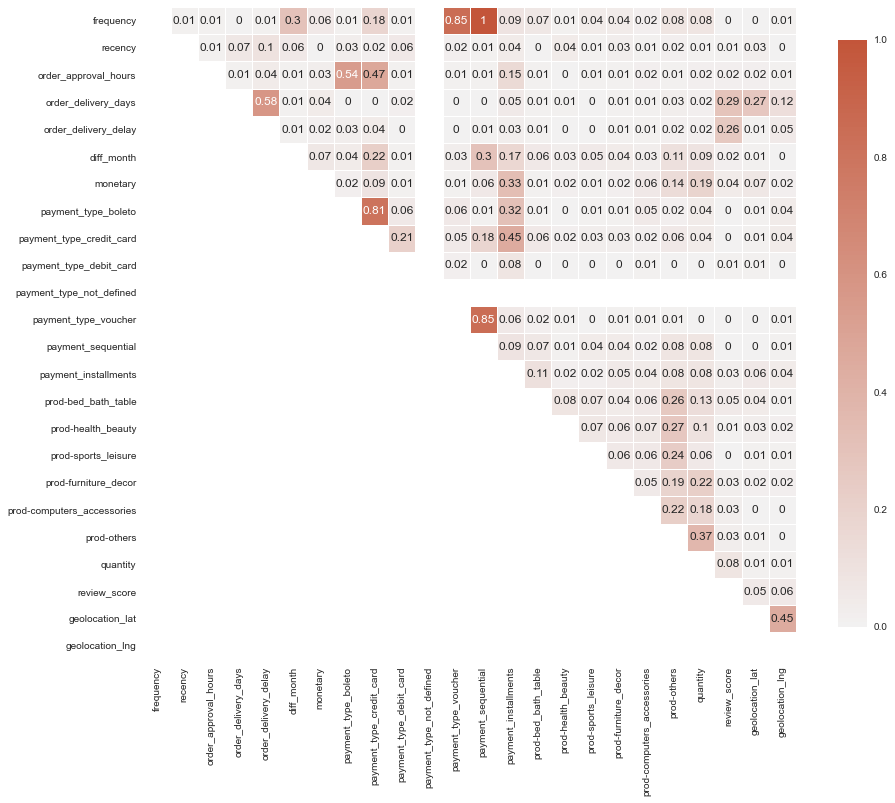

In [4]:
# Generate a mask for the upper triangle
corr_matrix = customers.corr().abs().round(2)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(upper,
            cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .9}, annot=True)

In [5]:
# Threshold for removing correlated variables
threshold=0.8
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

#drop highly relevent features 
df_final = customers.drop(columns=to_drop).fillna(0)
df_final.shape

(94399, 22)

- **Standardize features by removing the mean and scaling to unit variance**

In [6]:
def preprocess(data):
    """Preprocess data for clustering"""
       
    scaler = StandardScaler()
    data = data.set_index(['customer_unique_id'])
    std = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns)
    
    return std

#normalize two datasets
norm = preprocess(df_final)
norm_rfm = preprocess(rfm)


- **Apply PCA for the df dataset to project it to a lower dimensional space**

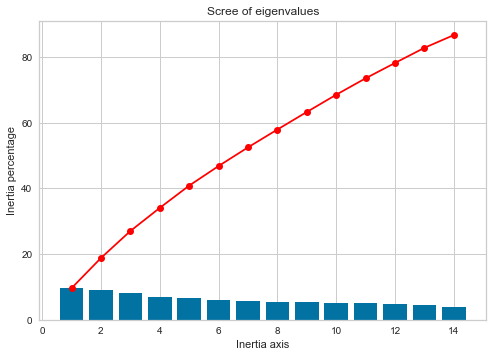

In [7]:
#select pca components as 14
n=14
pca = PCA(n_components=n)
pca.fit(norm)

#data visualisation with Scree of eigenvalue
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Inertia axis")
    plt.ylabel("Inertia percentage")
    plt.title("Scree of eigenvalues")
    plt.show(block=False)

display_scree_plot(pca)

More than 80% of features can be explained by 12 components

In [8]:
#Implement the probabilistic PCA model
n=12
pca = PCA(n_components=n).fit(norm)
X_projected = pca.transform(norm)
X_projected = pd.DataFrame(X_projected)
X_projected.columns = ['F'+str(i) for i in range(0, n)]
X_projected.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
0,0.03,0.95,-1.20,1.41,-0.07,-0.23,-0.31,-1.15,-1.01,-1.08,-1.02,-0.84
1,-0.77,-0.64,-0.98,0.80,0.20,-0.17,1.88,-1.43,0.45,0.83,0.62,0.14
2,1.46,0.29,-0.54,0.54,-1.87,0.45,-1.50,-0.24,0.60,0.02,0.86,1.29
3,1.78,-0.21,-0.81,-1.56,0.63,-0.04,-0.52,0.26,-0.20,0.11,0.44,0.25
4,0.17,0.79,-0.48,-0.29,-0.85,0.03,-0.41,-0.29,0.38,-0.11,0.18,-0.02


## Centroid based clustering with K Means

### case A : K means clustering with the dataset customers
- **first step : finding the best k value**

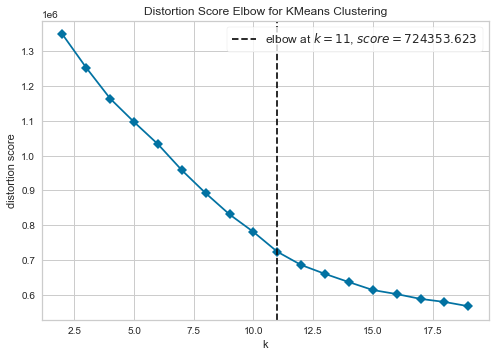

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=False)

In [9]:
#yellowbrick visualizer helps identify the best K value
kelbow_visualizer(KMeans(random_state=1),
                  X_projected,
                  k=(2, 20),
                  timings=False)

This suggests an optimal of 11 clusters, with the scoring parameter metric set to distortion, which computes the sum of squared distances from each point to its assigned center. 

- **step 2 : assigning all the points to the closest cluster centroid**

In [10]:
#use K=11 clusters to fit the dataset
kmeans11 = KMeans(init='k-means++', # to speed up convergence. 
                n_clusters=11,
                max_iter=500,
                random_state=1,
                verbose=0)

kmeans11_customers=kmeans11.fit(X_projected)

- **step 3 : mesuring average silhouette scores and intracluster distances**

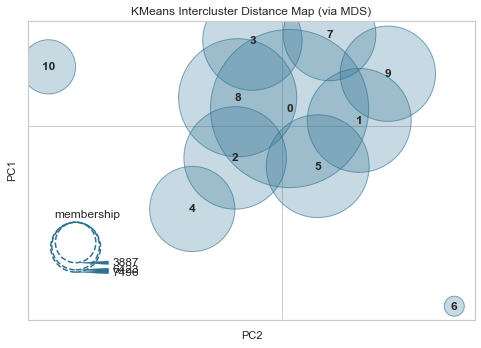

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=1,
                     scoring='membership')

In [11]:
#using principal component analysis to visualize the clustering in two dimensional space
intercluster_distance(kmeans11_customers, #estimator
                      X_projected,  #data
                      random_state=1)

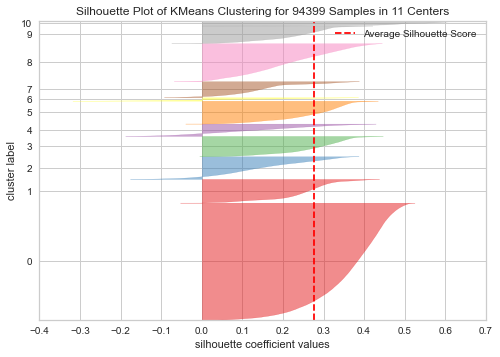

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94399 Samples in 11 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans11)

visualizer.fit(X_projected)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

The clusters are sized according to a the number of instances that belong to each center, so this gives a sense of the relative importance of clusters. Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.

- **step 4 : interpreting clusters using component pattern plots and score plots**

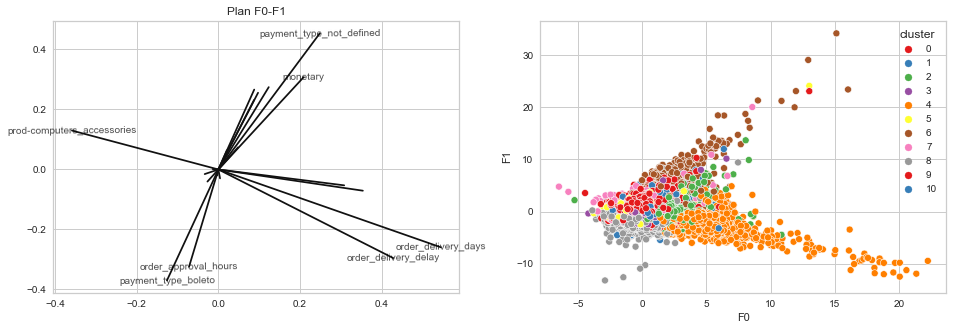

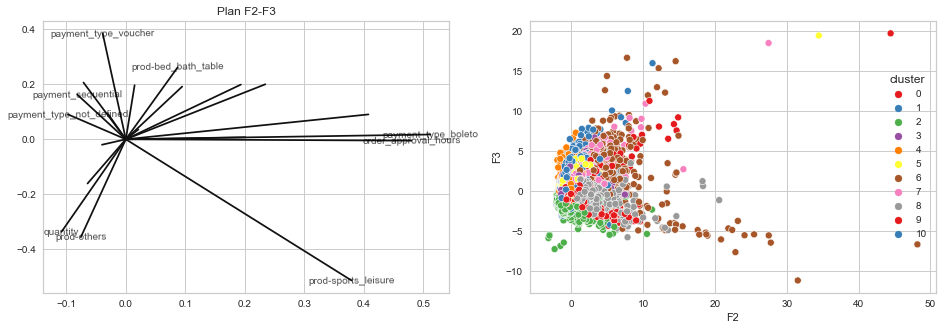

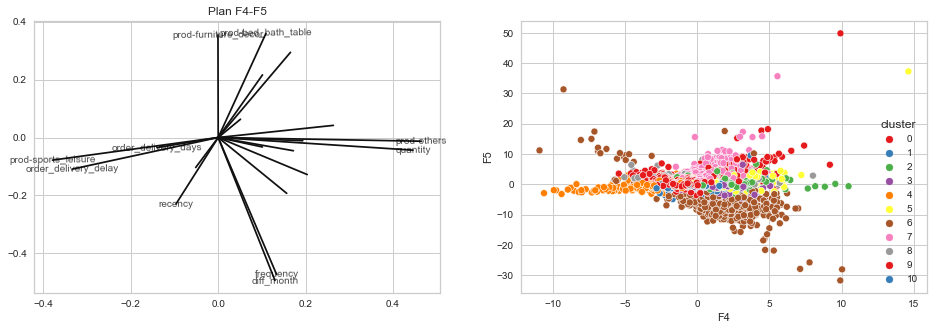

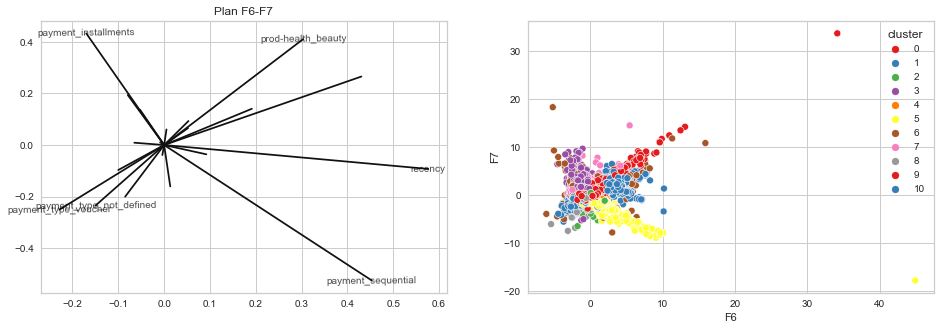

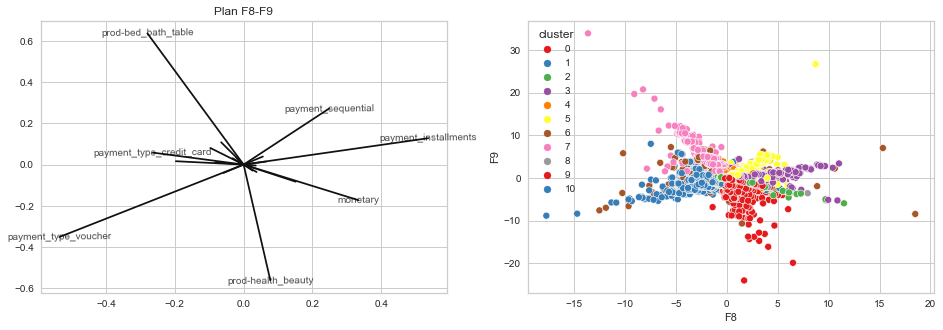

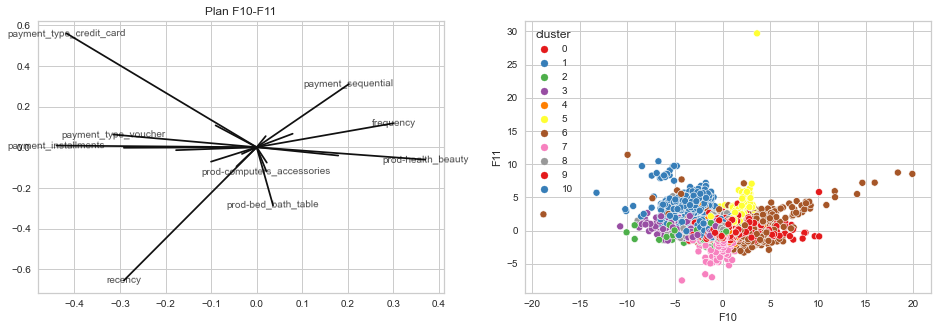

In [13]:
#add clusters
pcs = pca.components_
X_projected_clust = X_projected.assign(cluster=kmeans11_customers.labels_)


#put features projection and indivisual projection side by side
for j in range(0,n,2):
    # création de la fenêtre graphique 
    fig1, (axes) = plt.subplots(1,2,figsize=(16,5))
    
    plt.subplot(1,2,1)
        # détermination des limites du graphique
    arr1=pcs[j,:]
    arr2=pcs[j+1,:]
    plt.title('Plan F'+str(j)+'-F'+str(j+1))
    
    xmin, xmax = arr1[arr1.argsort()[2]], arr1[arr1.argsort()[-2]]
    ymin, ymax = arr2[arr2.argsort()[2]], arr2[arr2.argsort()[-2]]

    for i, (x, y) in enumerate(zip(pcs[j, :], pcs[j+1, :])):
        # Afficher un segment de l'origine au point (x, y)
        plt.plot([0, x], [0, y], color='k')
        # Afficher le nom (data.columns[i]) de la performance
        if x <= xmin or x >= xmax or y <= ymin or y >= ymax :
            plt.text(x, y, customers.columns[i+1], fontsize='10', ha='center', va='center', 
                     rotation=0.5, color="black", alpha=0.7)

    
    plt.subplot(1,2,2)
    # afficher chaque observation
    sns.scatterplot('F'+str(j), 'F'+str(j+1), data=X_projected_clust,
                    hue='cluster', palette='Set1', 
                    #ax=axes[1], 
                    legend='full')

    plt.show()

As the plots show, these defined groups are not that helpful for marketing strategy as they are just grouped by one or two caracteristics such as delay or a buying histroy of one particular product, which can be done by a single filter.

### case B : K means clustering with the dataset rfm
- **first step : finding the best k value**

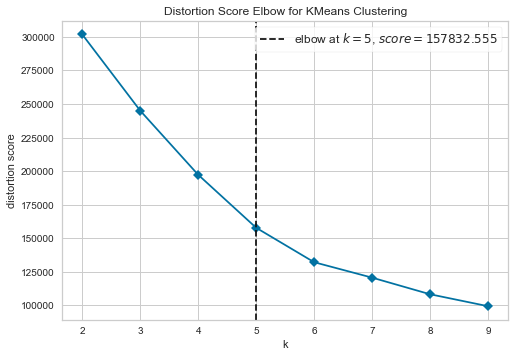

Wall time: 14.5 s


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=False)

In [14]:
%%time

#get the elbow
kelbow_visualizer(KMeans(random_state=1),
                  norm_rfm,
                  k=(2, 10),
                  timings=False)

This suggests an optimal of 5 clusters.

- **step 2 : assigning all the points to the closest cluster centroid**

In [15]:
#fit the data
kmeans5 = KMeans(init='k-means++', #set the initial cluster centroids
                algorithm='auto',
                n_clusters=5,
                max_iter=500,
                random_state=1,
                verbose=0)

kmeans_rfm= kmeans5.fit(norm_rfm)

- **step 3 : mesuring average silhouette scores and intracluster distances**

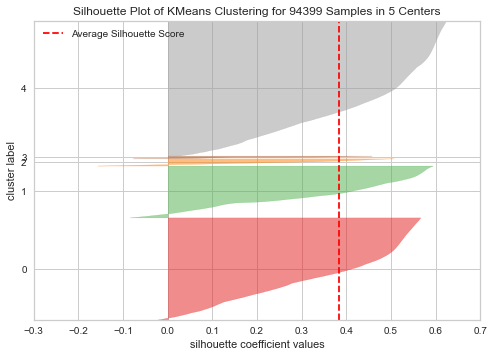

Wall time: 2min 59s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94399 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
%%time
#measure of how well each data point fits its corresponding cluster

# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans5)

visualizer.fit(norm_rfm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

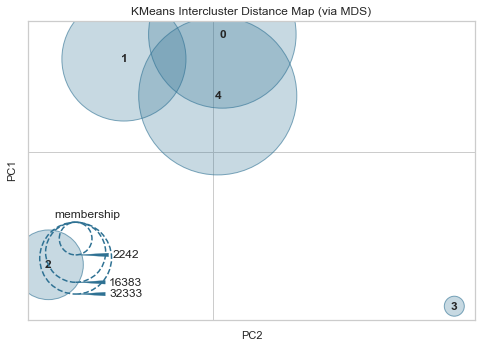

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=1,
                     scoring='membership')

In [17]:
#using principal component analysis to visualize the clustering in two dimensional space using yellowbrick.
intercluster_distance(kmeans_rfm, 
                      norm_rfm, 
                      random_state=1)

- **step 4 : calculating means of each cluster anbd plotting the clustered customers**

In [18]:
clusters_kmeans = rfm.assign(cluster=kmeans_rfm.labels_)

kmeans_clust_sizes=clusters_kmeans.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'review_score':'mean',
    'cluster':'count'
}).round(1).rename(columns={"cluster": "size"})

#calculate the relative size of each cluster
kmeans_clust_sizes['%total'] = kmeans_clust_sizes['size']/total

kmeans_clust_sizes

,recency,frequency,monetary,review_score,size,%total
cluster,,,,,,
0,-441.80,1.00,135.80,4.60,32333,0.34
1,-281.30,1.00,153.30,1.70,16383,0.17
2,-284.60,1.10,"1,216.70",4.10,2242,0.02
3,-291.60,4.20,228.70,4.10,875,0.01
4,-171.40,1.00,135.60,4.70,42566,0.45


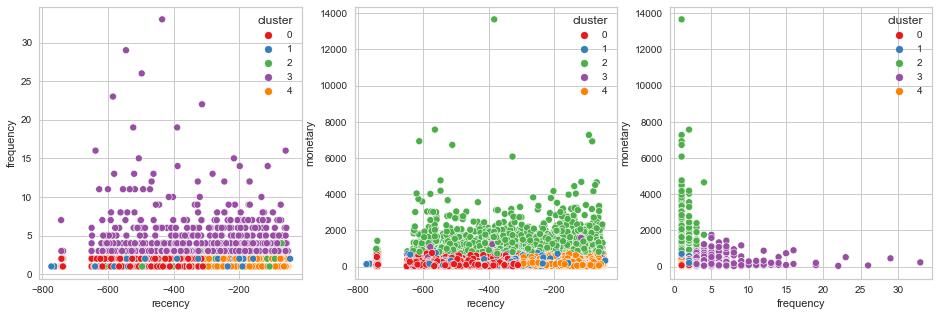

In [19]:
#projections of customers by cluster
fig1, (axes) = plt.subplots(1,3,figsize=(16,5))

scat_1 = sns.scatterplot('recency', 'frequency', data=clusters_kmeans,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

scat_2 = sns.scatterplot('recency', 'monetary', data=clusters_kmeans,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

scat_3 = sns.scatterplot('frequency', 'monetary', data=clusters_kmeans,
                hue='cluster', palette='Set1', ax=axes[2], legend='full')

plt.show()

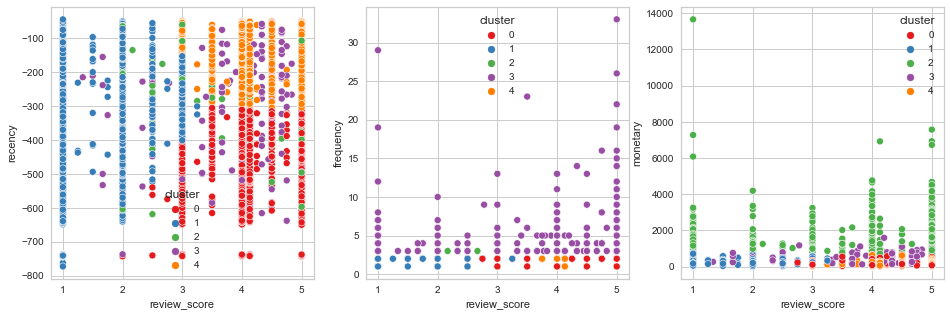

In [20]:
#projections of customers by cluster
fig1, (axes) = plt.subplots(1,3,figsize=(16,5))

scat_1 = sns.scatterplot('review_score', 'recency', data=clusters_kmeans,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

scat_2 = sns.scatterplot('review_score', 'frequency', data=clusters_kmeans,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

scat_3 = sns.scatterplot('review_score', 'monetary', data=clusters_kmeans,
                hue='cluster', palette='Set1', ax=axes[2], legend='full')

plt.show()

**These plots tell us that :**
- cluster 3 frequent buyers : have at least 5 shopping experiences at this store
- cluster 2 big spenders: have spent thousands of Brazil reals at the store.
- cluster 4 potential loyal customers:  have only one shopping experience at the store within a year and satisfied with their shopping expirence
- cluster 1 unsatisfied customers: ordered one or twice, but don't like their product or shopping experience
- cluster 0 lost customers: small spenders, and even though satisfied with their expirence, but haven't come back for more than a year

### Dataset selection : 
Compared to detailled customers dataset, the rfm method are more suitable to lead to an actionnable customer segmentation. So the the rfm dataset will be used for other clustering algorhisms.

## Distribution-based clustering with Gaussian Mixture Models (GMM)

- **first step : assigning rfm dataset as X**

In [21]:
#set norm_rfm as X for other clustering methods
X=norm_rfm

- **step 2 : assigning all the points to the closest cluster centroid**

In [22]:
#set 5 clusters for GMMS as Kmeans 
gmm5 = GaussianMixture(n_components=5, max_iter=500, init_params='kmeans',warm_start=True)

#fit the data
gmm = gmm5.fit(X)

- **step 3 : mesuring average silhouette scores**

In [46]:
%%time
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, gmm.predict(X), metric='euclidean'))

Silhouette Coefficient: 0.136
Wall time: 1min 31s


- **step 4 : calculating means of each cluster anbd plotting the clustered customers**

In [23]:
#calculate the distribution pattern
clusters_gmm = rfm.assign(cluster=gmm.predict(X))

gmm_clust_sizes=clusters_gmm.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'review_score':'mean',
    'cluster':'count'
}).round(1).rename(columns={"cluster": "size"})

#calculate the relative size of each cluster
gmm_clust_sizes['%total'] = gmm_clust_sizes['size']/total
gmm_clust_sizes

,recency,frequency,monetary,review_score,size,%total
cluster,,,,,,
0,-288.50,1.90,749.90,3.00,2102,0.02
1,-283.70,1.00,128.30,5.00,49966,0.53
2,-289.00,2.50,169.30,4.70,3865,0.04
3,-290.70,1.00,123.80,4.00,16714,0.18
4,-290.70,1.00,224.90,2.20,21752,0.23


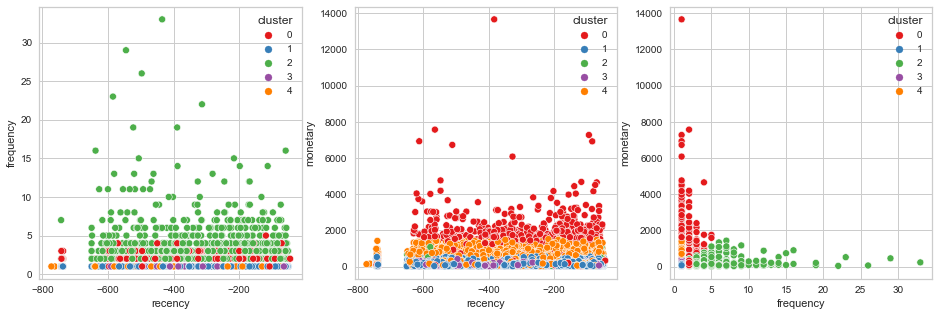

In [24]:
#projections of customers by cluster
fig1, (axes) = plt.subplots(1,3,figsize=(16,5))

scat_1 = sns.scatterplot('recency', 'frequency', data=clusters_gmm,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

scat_2 = sns.scatterplot('recency', 'monetary', data=clusters_gmm,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

scat_3 = sns.scatterplot('frequency', 'monetary', data=clusters_gmm,
                hue='cluster', palette='Set1', ax=axes[2], legend='full')

plt.show()

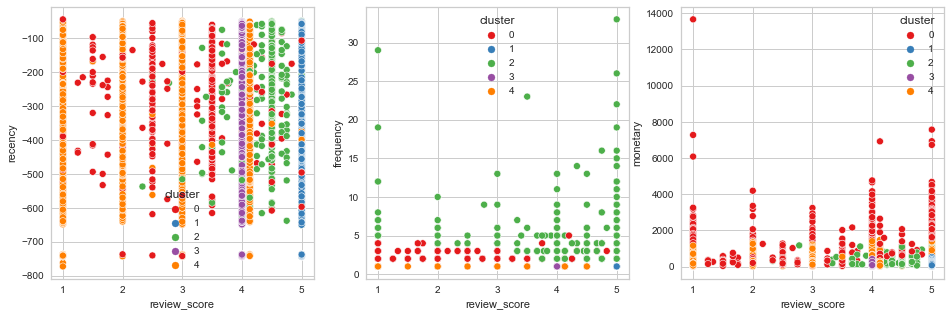

In [25]:
#projections of customers by cluster
fig1, (axes) = plt.subplots(1,3,figsize=(16,5))

scat_1 = sns.scatterplot('review_score', 'recency', data=clusters_gmm,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

scat_2 = sns.scatterplot('review_score', 'frequency', data=clusters_gmm,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

scat_3 = sns.scatterplot('review_score', 'monetary', data=clusters_gmm,
                hue='cluster', palette='Set1', ax=axes[2], legend='full')

plt.show()

These plots are quite similaire with kmeans, but compared to kmeans, some of clusters have no clear bounderies to tell one cluster from anotherrs, it will make the elaboration of marketing plans much more complicated.

## Density based clustering with DBSCAN

1. Unlike K-means, DBSCAN does not require the user to specify the number of clusters to be generated
2. DBSCAN can find any shape of clusters. The cluster doesn’t have to be circular.
3. DBSCAN can identify outliers

- **step 1 : getting approximative values for Eps (maximum radius of the neighborhood)**

(0.0, 1.0)

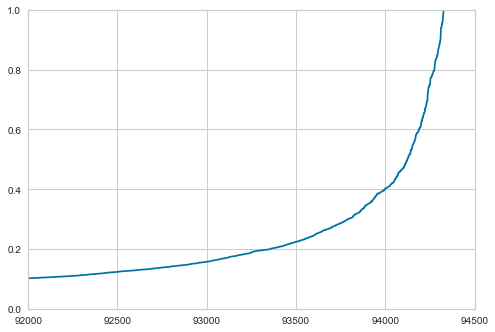

In [26]:
#calculate the neighborhood distance
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

#plot the distances and find the elbow
plt.plot(distances)
plt.xlim(left=92000,right=94500)
plt.ylim(bottom=0,top=1)

- **step 2 : investigating a range of values of eps and min_samples to find the best fit**

In [27]:
#define the ranges
eps_values = np.arange(0.3,0.45,0.05) # eps values to be investigated
min_samples = np.arange(5,40,5) # min_samples values to be investigated

dbscan_params = list(product(eps_values.round(2), min_samples))

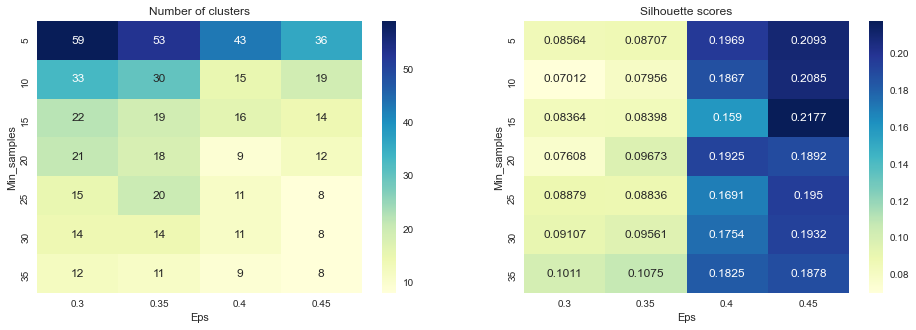

In [28]:
#reload silhouette score results
no_of_clusters = pd.read_csv(outputWD +  'no_of_clusters.csv').iloc[:,0].values.tolist()
sil_score = pd.read_csv(outputWD +  'sil_score.csv').iloc[:,0].values.tolist()

#put all in a dataframe
tmp = pd.DataFrame.from_records(dbscan_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters
tmp['Sil_score'] = sil_score

#visualize results
fig, (axes) = plt.subplots(1,2,figsize=(16,5))

#create plot datasets 
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')
pivot_2 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

sns.heatmap(pivot_1, annot=True,annot_kws={"size": 12}, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Number of clusters')

sns.heatmap(pivot_2, annot=True,  fmt='.4g', annot_kws={"size": 12}, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Silhouette scores')

plt.show()

- **step 2 : assigning all the points to clusters (+ outliers) using euclidean distance**

In [29]:
dbs = DBSCAN(eps=0.45, min_samples=15).fit(X)

- **step 3 : mesuring average silhouette score**

In [30]:
%%time
#measure of how well each data point fits its corresponding cluster
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, dbs.labels_))

Silhouette Coefficient: 0.218
Wall time: 1min 40s


- **step 4 : calculating means of each cluster anbd plotting the clustered customers**

In [31]:
#calculate the distribution pattern
clusters_dbs = rfm.copy()
clusters_dbs.loc[:,'cluster'] = dbs.labels_ # append labels to points

dbs_clust_sizes= clusters_dbs.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'review_score':'mean',
    'cluster':'count'
}).round(1).rename(columns={"cluster": "size"})

#calculate the relative size of each cluster
dbs_clust_sizes['%total'] = dbs_clust_sizes['size']/total
dbs_clust_sizes

,recency,frequency,monetary,review_score,size,%total
cluster,,,,,,
-1,-328.50,2.70,"1,035.60",3.40,1402,0.01
0,-285.30,1.00,149.20,4.10,87999,0.93
1,-286.30,2.00,185.30,4.20,4349,0.05
2,-740.40,1.00,106.90,4.00,45,0.00
3,-140.60,1.00,"2,059.10",5.00,46,0.00
4,-287.10,3.00,138.70,4.80,269,0.00
5,-389.20,1.00,"1,663.60",5.00,23,0.00
6,-740.50,1.00,133.30,5.00,118,0.00
7,-742.90,1.00,108.00,1.00,34,0.00


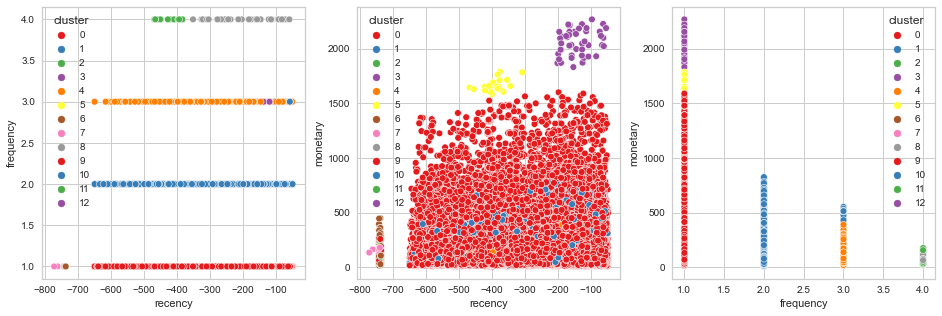

In [32]:
#get the list of outliers
dbs_outliers = clusters_dbs[clusters_dbs['cluster']==-1]
dbs_clusters= clusters_dbs[clusters_dbs['cluster']!=-1]

#plotting clusters
fig1, (axes) = plt.subplots(1,3,figsize=(16,5))

scat_1 = sns.scatterplot('recency', 'frequency',data=dbs_clusters,
                hue='cluster', ax=axes[0], palette='Set1', legend='full', s=45)
scat_2 = sns.scatterplot('recency', 'monetary',data=dbs_clusters,
                hue='cluster', palette='Set1', ax=axes[1], legend='full', s=45)
scat_3 = sns.scatterplot('frequency', 'monetary', data=dbs_clusters,
                hue='cluster', palette='Set1', ax=axes[2], legend='full', s=45)
plt.show()

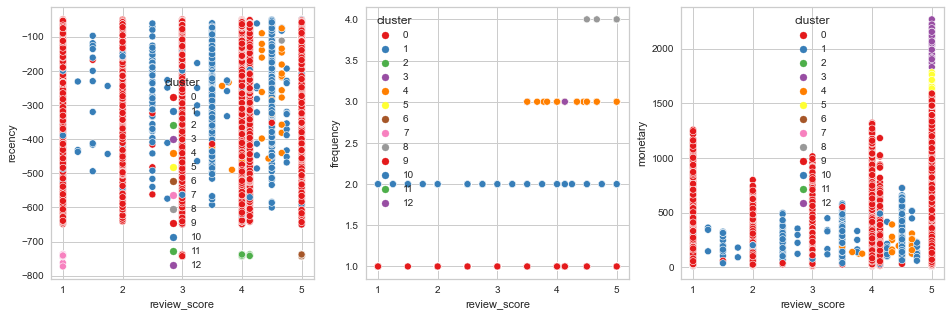

In [33]:
#projections of customers by cluster
fig1, (axes) = plt.subplots(1,3,figsize=(16,5))

scat_1 = sns.scatterplot('review_score', 'recency', data=dbs_clusters,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

scat_2 = sns.scatterplot('review_score', 'frequency', data=dbs_clusters,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

scat_3 = sns.scatterplot('review_score', 'monetary', data=dbs_clusters,
                hue='cluster', palette='Set1', ax=axes[2], legend='full')

plt.show()

We can read from the synthesis that most high spenders and frequent buyers are considered as outliers. Plus, clusters are not defined in a equitable way, the cluster 0 concentrates 93% of customers. 

All this leads up to the conclusion that dbscan clustering is not suitable segmentation method for those customers.

## Mixed method : kmeans + hierarchical clustering 

Hierarchical clustering algorithms can be either agglomerative or divisive, In agglomerative hier-archical clustering each data point starts out as an individual cluster and clusters arebuilt from the bottom up; in divisive hierarchical clustering all of the data starts outas a single cluster that is successively divided into multiple clusters. 


The problem with hierarchical clustering algorithm is that they scale poorly in both memory and computing time, because the distance matrix needs to be precalculated and stored in memory. And the results are not at all convincing usually. In particular for one hundred thousand of customers, where we can't just look at the dendrogram to choose the appropriate cut.

That's why here we use a mixed method of Kmeans and hierarchical clustering.

- **step 1 : using Kmeans to create a greate number of clusters**

In [115]:
%%time

#fit the data
kmeans_n = KMeans(init='k-means++', #set the initial cluster centroids
                algorithm='auto',
                n_clusters=1000,
                random_state=1,
                verbose=0).fit(X)

Wall time: 8min 59s


- **step 2 : using kmeans centroids as points for hierarchical clustering**

In [116]:
X_kmeans= pd.DataFrame(kmeans_n.cluster_centers_, columns=X.columns)

- **step 3 : mesuring scores to find the best k value**

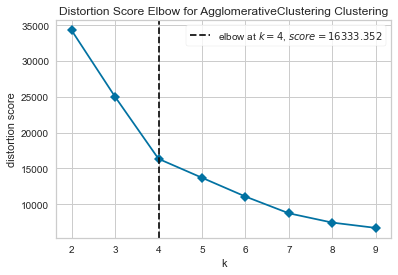

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=False)

In [117]:
#get the elbow with distortion score
kelbow_visualizer(AgglomerativeClustering(linkage='ward'),
                 X_kmeans,
                  k=(2, 10),
                  timings=False)

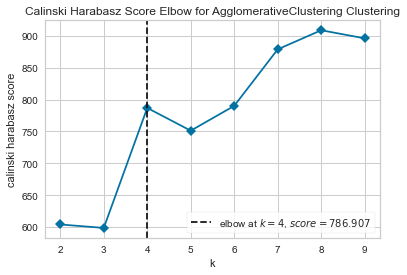

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 k=None, locate_elbow=True, metric='calinski_harabasz',
                 model=None, timings=False)

In [125]:
#get the elbow with calinski_harabasz score
kelbow_visualizer(AgglomerativeClustering(linkage='ward'),
                 X_kmeans,
                  metric='calinski_harabasz',
                  k=(2, 10),
                  timings=False)

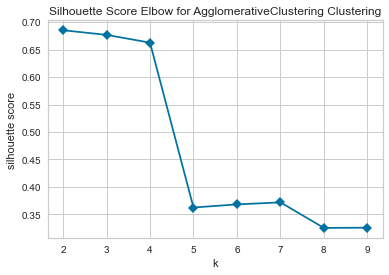

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=False)

In [126]:
#get the elbow with silhouette score
kelbow_visualizer(AgglomerativeClustering(linkage='ward'),
                 X_kmeans,
                  metric='silhouette',
                  k=(2, 10),
                  timings=False)

**all scores pointed that the 4 is the best fit.**

In [128]:
#measure of how well each data point fits its corresponding cluster
print("Silhouette Coefficient: %0.3f"%silhouette_score(X_kmeans, cah.labels_))

Silhouette Coefficient: 0.663


- **step 4 : using aglomerative method as final clustering to fit the data**

In [119]:
cah=AgglomerativeClustering(n_clusters=4,linkage='ward').fit(X_kmeans)

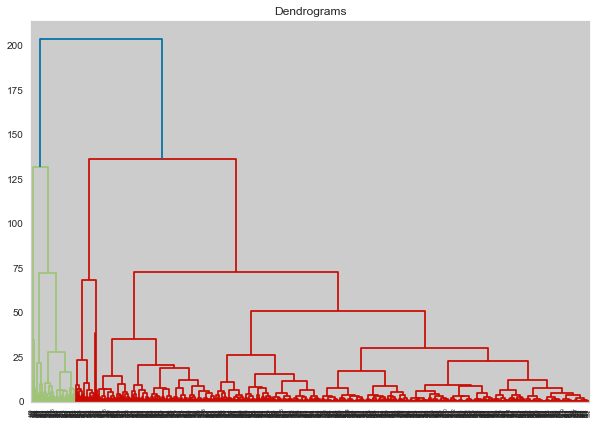

In [118]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_kmeans, method='ward'))

- **step 5 : calculating means of each cluster anbd plotting the clustered customers**

In [123]:
#assign kmeans labels to points
cah_clusters = rfm.copy()
cah_clusters.loc[:,'cluster'] = kmeans_n.labels_ 
#create a map from kmeans to CAH
clusters_map = dict(zip(X_kmeans.index.tolist(), cah.labels_))
#replace kmeans clusters by cah clusters
cah_clusters['cluster'].replace(clusters_map, inplace=True)

#create a summary table
cah_clust_sizes= cah_clusters.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'review_score':'mean',
    'cluster':'count'
}).round(1).rename(columns={"cluster": "size"})

#calculate the relative size of each cluster
cah_clust_sizes['%total'] = cah_clust_sizes['size']/total
cah_clust_sizes

,recency,frequency,monetary,review_score,size,%total
cluster,,,,,,
0,-286.80,1.10,161.50,4.10,94085,1.00
1,-300.30,6.80,291.90,4.20,206,0.00
2,-298.60,1.20,"3,374.20",4.00,101,0.00
3,-469.70,24.40,229.20,3.60,7,0.00


This clustering is clearly no use for marketing purpose as almost all of them assigned to a one cluster.

## Conclusion
From the above comparisons, it is clear that DBSCAN and HDSCAN failed to generate reasonable clusters. It is due to its problems in recognising clusters of low densities points, which reprensent the most precious costumers in this case.

In turn, K-Means and  MMGS algorithms created reasonable 5 clusters, and K means gives us the most insightful clusters du to their homogeneity.

**Kmeans clusters:**
- cluster 4 potential loyal customers:  have only one shopping experience at the store within a year and satisfied with their shopping expirence
- cluster 3 frequent buyers : have at least 5 shopping experiences at this store
- cluster 2 big spenders: have spent thousands of Brazil reals at the store.
- cluster 1 unsatisfied customers: ordered one or twice, but don't like their product or shopping experience
- cluster 0 lost customers: small spenders, and even though satisfied with their expirence, but haven't come back for more than a year

**Assign labels to customer segments** 

In [40]:
#Labeling the customers by segment
segments = {0:'lost', 2:'big spenders',4:'potential loyal customers',3:'frequent buyers',1:'unsatisfied customers'}

clusters_kmeans['segment'] = clusters_kmeans['cluster'].map(segments)
print(clusters_kmeans.shape)
clusters_kmeans.head()

(94399, 7)


,customer_unique_id,recency,frequency,monetary,review_score,cluster,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,-160.27,1,141.90,5.00,4,potential loyal customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-163.26,1,27.19,4.00,4,potential loyal customers
2,0000f46a3911fa3c0805444483337064,-585.85,1,86.22,3.00,0,lost
3,0000f6ccb0745a6a4b88665a16c9f078,-369.88,1,43.62,4.00,0,lost
4,0004aac84e0df4da2b147fca70cf8255,-336.91,1,196.89,5.00,0,lost
